In [1]:
import time                      # import libraries
start_time = time.time()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import imblearn
from imblearn.over_sampling import SMOTE
import collections
from tqdm import tqdm_notebook as tqdm

from sklearn.preprocessing import StandardScaler      # import sklearn libraries
from sklearn import datasets, model_selection
from sklearn.metrics import plot_confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix,plot_roc_curve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.naive_bayes import GaussianNB

from xgboost import XGBClassifier                     # import non-sklearn algorithm libraries
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


In [2]:
df = pd.read_csv('./DATA/creditcard_train1.csv')     # import train csv files to dataframes
df2 = pd.read_csv('./DATA/creditcard_train2.csv')
df = pd.concat([df,df2[1:]])                        # merge the 2 dataframes
del df2                                             # delete the one of the dataframes

In [3]:
df.isnull().sum().sum()   # Check if there is any Nan in the dataframe

0

In [4]:
features_list = df.columns.values.tolist()  # create a list for the name of all the features
for list_idx in features_list:
    print(list_idx, end=' ')               # printing the list of features and label
features_list.pop()                        # deleting the list entity of the list as it is the label(not feature)
print("\n")
for list_idx in features_list:
    print(list_idx, end=' ')               # printing the list of only features

Time V1 V2 V3 V4 V5 V6 V7 V8 V9 V10 V11 V12 V13 V14 V15 V16 V17 V18 V19 V20 V21 V22 V23 V24 V25 V26 V27 V28 Amount Class 

Time V1 V2 V3 V4 V5 V6 V7 V8 V9 V10 V11 V12 V13 V14 V15 V16 V17 V18 V19 V20 V21 V22 V23 V24 V25 V26 V27 V28 Amount 

In [5]:
df.Class.unique()  # ensuring the Class column is binary as expected

array([0, 1], dtype=int64)

In [6]:
df.Class=df.Class.astype("bool")  # converting the Class label to boolean type from int64
collections.Counter(df.Class)       # checking how inbalance is our data

Counter({False: 198998, True: 364})

In [7]:
df.duplicated().sum()    # Check for duplication

585

In [8]:
df.drop_duplicates(inplace = True)  # keeping only one of the duplication rows if there is any
collections.Counter(df.Class)        # check again how our inbalance data looks like

Counter({False: 198422, True: 355})

In [9]:
px.histogram(df, "Class", labels={"Class": "Fraudness"}, title="Count of Credit Card Transactions",color="Class" ,color_discrete_map = {True:'red',False:'blue'})

In [10]:
fraud_count = df.Class[df["Class"]==True].count() # counting the number of fraud and clean transactions
clean_count = len(df) - fraud_count
print('Number of fraud Transactions is ', fraud_count ,' which is ', round(100*fraud_count/len(df),3) , "% of the dataset.\n")
print('Number of clean Transactions is ', clean_count ,' which is ', round(100*clean_count/len(df),3) , "% of the dataset.")

Number of fraud Transactions is  355  which is  0.179 % of the dataset.

Number of clean Transactions is  198422  which is  99.821 % of the dataset.


In [11]:
df_label=df["Class"]                    # creating a label only dataframe
df_features = df.drop("Class", axis=1)   # creating a feature only dataframe

In [12]:
# Separating the train and validation sets for both labels and feautures
X_train, X_val, Y_train, Y_val = train_test_split(df_features, df_label, test_size=0.33, random_state=42)

In [13]:
df.describe() # check the description of all the numeric features(which are all the features) 

Time             V1             V2             V3  \
count  198777.000000  198777.000000  198777.000000  198777.000000   
mean    94804.312295       0.009128      -0.002808      -0.001230   
std     47505.945585       1.945998       1.634265       1.513868   
min         0.000000     -56.407510     -72.715728     -48.325589   
25%     54213.000000      -0.914367      -0.600632      -0.891180   
50%     84650.000000       0.025907       0.063052       0.177015   
75%    139333.000000       1.317510       0.798376       1.024675   
max    172792.000000       2.454930      22.057729       9.382558   

                  V4             V5             V6             V7  \
count  198777.000000  198777.000000  198777.000000  198777.000000   
mean       -0.002365      -0.002014       0.002832       0.001295   
std         1.415270       1.386037       1.335744       1.243473   
min        -5.683171    -113.743307     -26.160506     -43.557242   
25%        -0.848943      -0.691728      -0.768274      -0.554928   
50%        -0.022399      -0.054543      -0.273589       0.038361   
75%         0.739895       0.611792       0.398343       0.567914   
max        16.875344      34.801666      73.301626     120.589494   

                  V8             V9  ...            V20            V21  \
count  198777.000000  198777.000000  ...  198777.000000  198777.000000   
mean       -0.001479       0.001572  ...      -0.000200      -0.000324   
std         1.177720       1.099267  ...       0.769537       0.725705   
min       -50.688419     -13.434066  ...     -54.497720     -22.889347   
25%        -0.208845      -0.642858  ...      -0.211763      -0.228663   
50%         0.021971      -0.049979  ...      -0.062789      -0.030281   
75%         0.325913       0.599765  ...       0.131815       0.185224   
max        20.007208      15.594995  ...      38.117209      27.202839   

                 V22            V23            V24            V25  \
count  198777.000000  198777.000000  198777.000000  198777.000000   
mean       -0.001453      -0.000254       0.000687      -0.000352   
std         0.724582       0.631072       0.605287       0.521072   
min        -9.499423     -44.807735      -2.824849     -10.295397   
25%        -0.542464      -0.161780      -0.354038      -0.317835   
50%         0.006057      -0.010666       0.041286       0.015550   
75%         0.526075       0.148339       0.440253       0.350490   
max         8.361985      22.083545       4.584549       7.519589   

                 V26            V27            V28         Amount  
count  198777.000000  198777.000000  198777.000000  198777.000000  
mean        0.000263       0.001165       0.000728      88.854125  
std         0.482129       0.399762       0.328130     253.999620  
min        -2.604551     -22.565679     -15.430084       0.000000  
25%        -0.326248      -0.070785      -0.052444       5.510000  
50%        -0.052173       0.001340       0.011317      22.000000  
75%         0.240273       0.090650       0.078043      77.070000  
max         3.517346      31.612198      33.847808   25691.160000  

[8 rows x 30 columns]

In [14]:
scalar = StandardScaler()   # Standardising Time and Amount in traning dataframe
X_val[['Time', 'Amount']] = scalar.fit_transform(X_val[['Time', 'Amount']])

scalar = StandardScaler()   #  Standardising Time and Amount in validation dataframe
X_val[['Time', 'Amount']] = scalar.fit_transform(X_val[['Time', 'Amount']])

In [15]:
df_train = pd.DataFrame(X_train, copy = True)  # creating a training dataframe with all the features and label
df_train["Class"]=Y_train

In [16]:
df_fraud = df_train[df_train.Class==True]                    # creating a fraud only dataframe
df_clean = df_train[df_train.Class==False].sample(frac=.1)   # creating a clean only dataframe with the desired size

In [17]:
df_train = pd.concat([df_fraud, df_clean])    # merging the fraud and the clean(reduced size) dataframes
collections.Counter(df_train.Class)           

Counter({True: 247, False: 13293})

In [18]:
px.histogram(df_train, "Class", labels={"Class": "Fraudness"}, title="Count of Credit Card Transactions",color="Class" ,color_discrete_map = {True:'red',False:'blue'})

In [19]:
df_label=df_train["Class"]   # splitting the training dataframe to abel and features to prepare for SMOTE
df_features = df_train.drop("Class", axis=1)                      

In [20]:
sm = SMOTE(random_state=42)  # oversampling the training dataset to have same number of fraud and clean transactions
X_train, Y_train = sm.fit_sample(df_features, df_label)  

In [21]:
df_balanced = pd.DataFrame(X_train, copy = True) # Creating a new balanced dataframe
df_balanced["Class"]=Y_train

In [22]:
px.histogram(df_balanced, "Class", labels={"Class": "Fraudness"}, title="Count of Credit Card Transactions",color="Class" ,color_discrete_map = {True:'red',False:'blue'})

--- 1.0 minutes ---


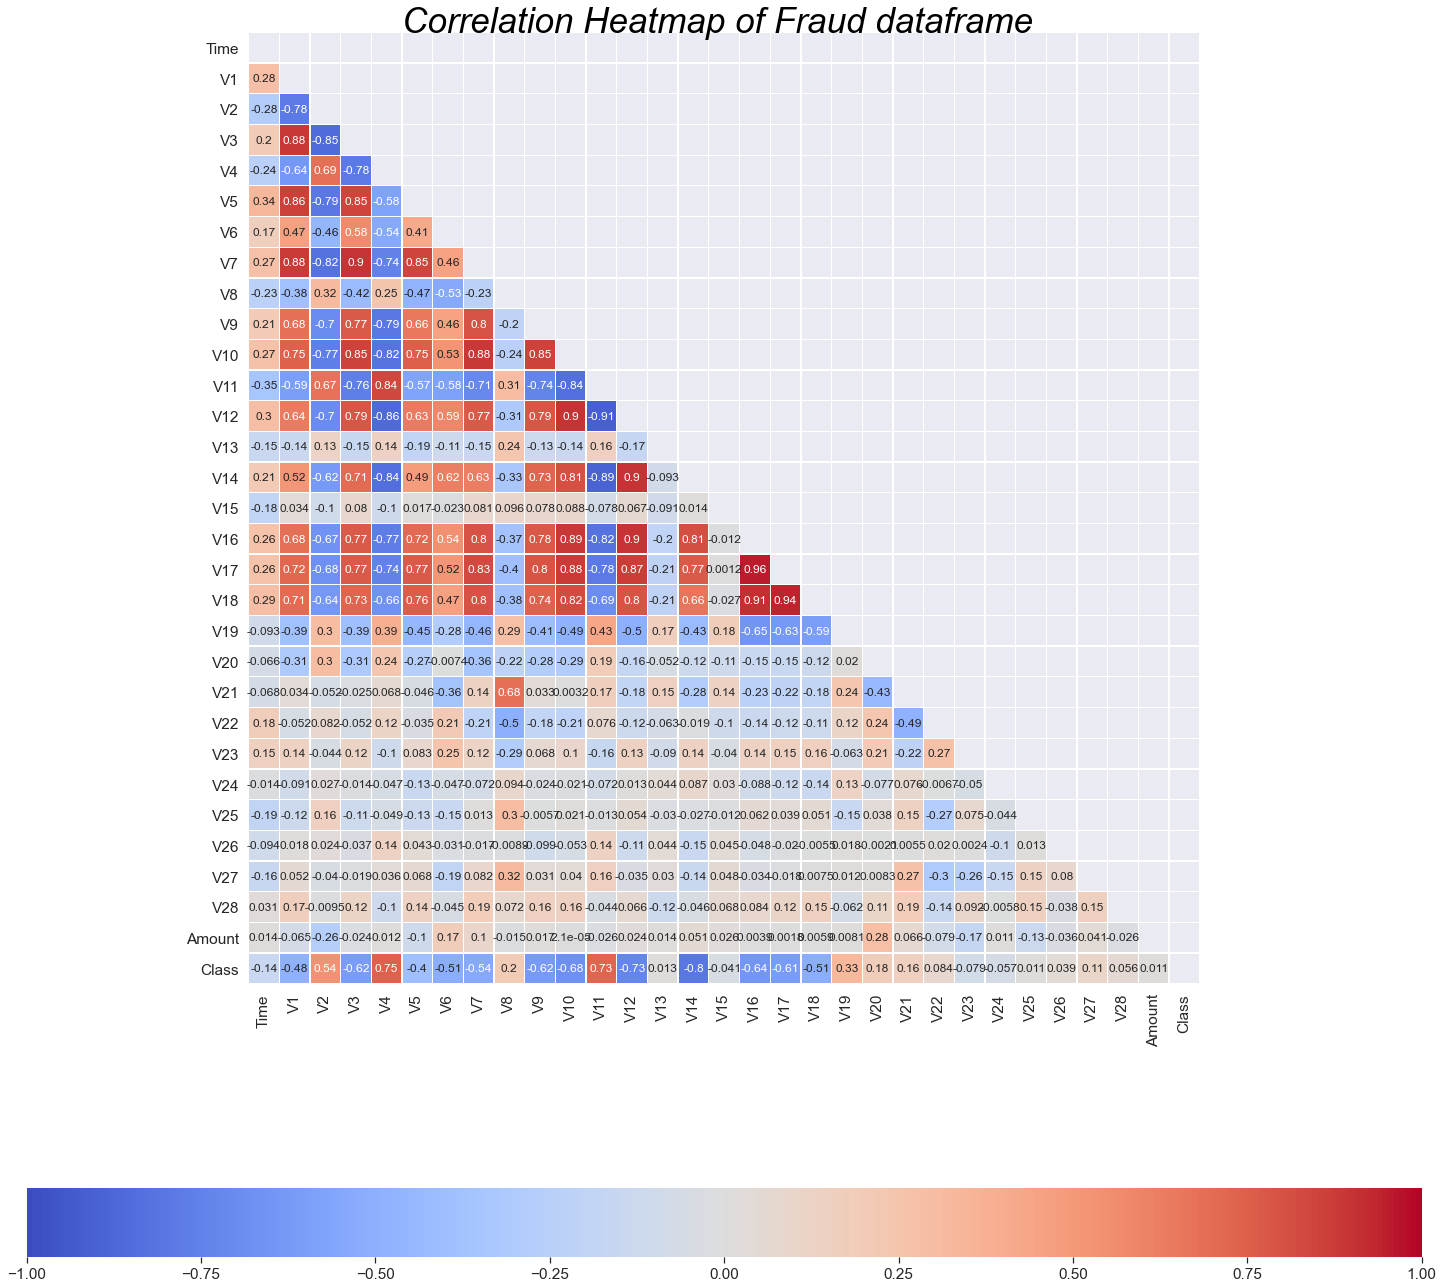

In [23]:
sns.set_theme(style="white")
sns.set(font_scale=1.4)
# Compute the correlation matrix
corr = df_balanced.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(25, 25))
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=1,vmin=-1, center=0, annot=True, annot_kws={"size": 12}, fmt='.2g',square=True, linewidths=.3,cbar_kws= {'orientation': 'horizontal'})
plt.text(5,0, "Correlation Heatmap of Fraud dataframe", fontsize = 35, color='Black', fontstyle='italic')
print("--- %s minutes ---" % round((time.time() - start_time)/60,0))

In [24]:
to_remove_list = ['Time','V1','V5','V6','V7','V8','V13','V15','V18','V19','V20','V21','V22','V23','V24','V25','V26','V27','V28','Amount']      # List of the features we don't want to keep
remaining_features_list = [x for x in features_list if x not in to_remove_list] 
remaining_features_list      # Creating the remaining features list after excluding the unwanted features

['V2', 'V3', 'V4', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17']

In [25]:
df_balanced.drop(columns=to_remove_list, inplace=True) # droping the unwanted features from the balanced dataframe

--- 1.0 minutes ---


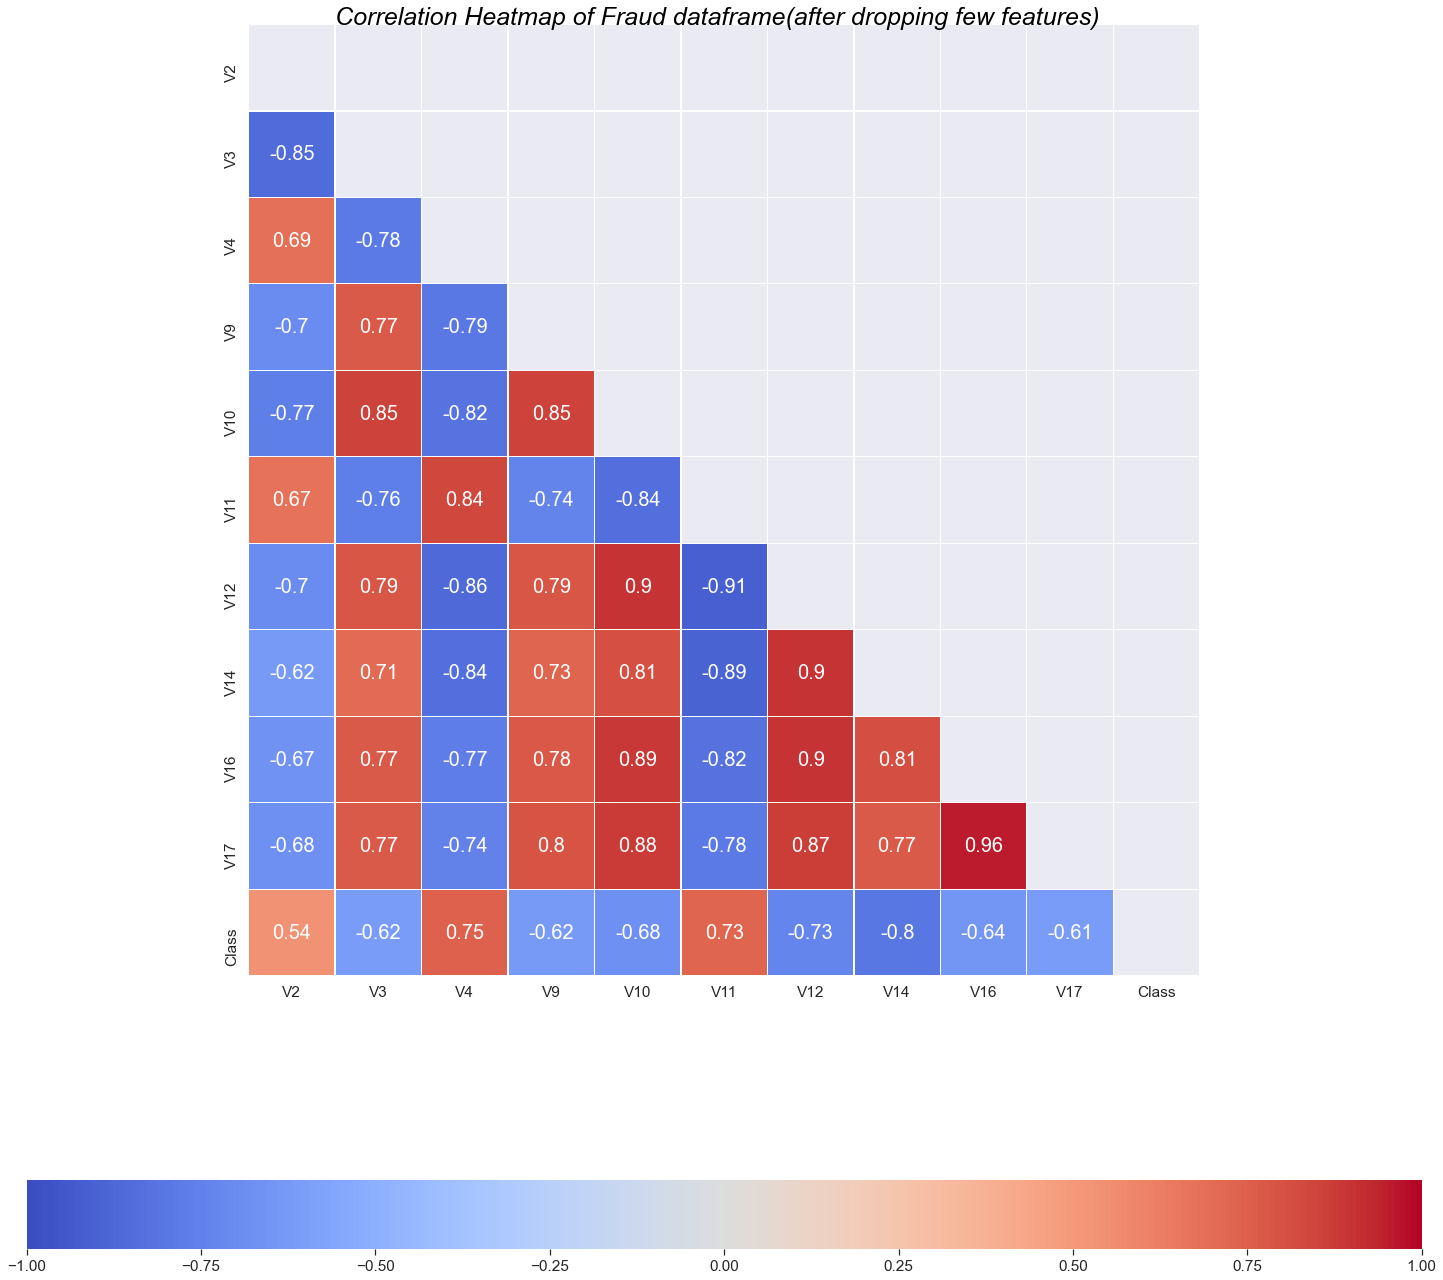

In [26]:
sns.set_theme(style="white")
sns.set(font_scale=1.4)
# Compute the correlation matrix
corr = df_balanced.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(25, 25))
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=1,vmin=-1, center=0, annot=True, annot_kws={"size": 20}, fmt='.2g',square=True, linewidths=.3,cbar_kws= {'orientation': 'horizontal'})
plt.text(1,0, "Correlation Heatmap of Fraud dataframe(after dropping few features)", fontsize = 25, color='Black', fontstyle='italic')
print("--- %s minutes ---" % round((time.time() - start_time)/60,0))

In [27]:
#similar_corr_list = ['V11','V12','V16','V17']          # List of more features we don't want to keep
#to_remove_list = similar_corr_list + to_remove_list
#remaining_features_list = [x for x in remaining_features_list if x not in to_remove_list]
#remaining_features_list

In [28]:
#df_balanced.drop(columns=similar_corr_list, inplace=True) # Drop the unwanted features from the dataframe

In [29]:
X_train.drop(columns=to_remove_list, inplace=True)  # Drop unwanted features from the training dataframe
X_val.drop(columns=to_remove_list, inplace=True)    # Drop unwanted features from the validation dataframe